In [11]:
import numpy as np
import pandas as pd
import math
# import argparse
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
pocketlist = ["/Users/faisal/2_Research/bindingdb_cnn/test_pocket1.pdb","/Users/faisal/2_Research/bindingdb_cnn/test_pocket2.pdb","/Users/faisal/2_Research/bindingdb_cnn/test_pocket3.pdb"]
model_pockets = ([])

for pocket in pocketlist:
    

    pdbfile = pocket

    remark_count=0

    column_names = ["record_name", "serial_number", "atom_name", "residue", "chain", "res_seq", "orth_x", "orth_y", "orth_z", "occupancy", "temp_factor", "element_plus_charge"]

    pdb = pd.read_csv(pdbfile, sep='\t', skiprows=remark_count, header=None, names = column_names)

    pdbmask = pdb['record_name'].str.startswith('ATOM') | pdb['record_name'].str.startswith('HETATM')
    pdb = pdb[pdbmask]

    pdb['serial_number']=pdb['record_name'].str.slice(start=6,stop=11).str.strip()
    pdb['atom_name']=pdb['record_name'].str.slice(start=11,stop=16).str.strip()
    pdb['residue']=pdb['record_name'].str.slice(start=16,stop=20).str.strip()
    pdb['chain']=pdb['record_name'].str.slice(start=20,stop=22).str.strip()
    pdb['res_seq']=pdb['record_name'].str.slice(start=22,stop=26).str.strip()
    pdb['orth_x']=pdb['record_name'].str.slice(start=30,stop=38).str.strip().astype(float)
    pdb['orth_y']=pdb['record_name'].str.slice(start=38,stop=46).str.strip().astype(float)
    pdb['orth_z']=pdb['record_name'].str.slice(start=46,stop=54).str.strip().astype(float)
    pdb['occupancy']=pdb['record_name'].str.slice(start=54,stop=60).str.strip()
    pdb['temp_factor']=pdb['record_name'].str.slice(start=60,stop=66).str.strip()
    pdb['element_plus_charge']=pdb['record_name'].str.slice(start=66,stop=79).str.strip()
    pdb['record_name']=pdb['record_name'].str.slice(stop=6).str.strip()

    pdb_select = pdb[['orth_x', 'orth_y', 'orth_z', 'residue', 'element_plus_charge']]
    
    numeric_columns = pdb_select.select_dtypes(include=['number']).astype('float64')
    string_columns = pdb_select.select_dtypes(include=['object'])
    string_array = string_columns.to_numpy()
    model_pockets.append(np.transpose(np.concatenate([numeric_columns, string_array], axis=1))) # to keep array remove 'tolist()'

In [5]:
ligandlist = ["/Users/faisal/2_Research/bindingdb_cnn/test_ligand1.pdb","/Users/faisal/2_Research/bindingdb_cnn/test_ligand2.pdb","/Users/faisal/2_Research/bindingdb_cnn/test_ligand3.pdb"]
model_ligands = ([])

for ligand in ligandlist:
    

    pdbfile = ligand

    remark_count=0

    column_names = ["record_name", "serial_number", "atom_name", "residue", "chain", "res_seq", "orth_x", "orth_y", "orth_z", "occupancy", "temp_factor", "element_plus_charge"]

    pdb = pd.read_csv(pdbfile, sep='\t', skiprows=remark_count, header=None, names = column_names)

    pdbmask = pdb['record_name'].str.startswith('ATOM') | pdb['record_name'].str.startswith('HETATM')
    pdb = pdb[pdbmask]

    pdb['serial_number']=pdb['record_name'].str.slice(start=6,stop=11).str.strip()
    pdb['atom_name']=pdb['record_name'].str.slice(start=11,stop=16).str.strip()
    pdb['residue']=pdb['record_name'].str.slice(start=16,stop=20).str.strip()
    pdb['chain']=pdb['record_name'].str.slice(start=20,stop=22).str.strip()
    pdb['res_seq']=pdb['record_name'].str.slice(start=22,stop=26).str.strip()
    pdb['orth_x']=pdb['record_name'].str.slice(start=30,stop=38).str.strip().astype(float)
    pdb['orth_y']=pdb['record_name'].str.slice(start=38,stop=46).str.strip().astype(float)
    pdb['orth_z']=pdb['record_name'].str.slice(start=46,stop=54).str.strip().astype(float)
    pdb['occupancy']=pdb['record_name'].str.slice(start=54,stop=60).str.strip()
    pdb['temp_factor']=pdb['record_name'].str.slice(start=60,stop=66).str.strip()
    pdb['element_plus_charge']=pdb['record_name'].str.slice(start=66,stop=79).str.strip()
    pdb['record_name']=pdb['record_name'].str.slice(stop=6).str.strip()

    pdb_select = pdb[['orth_x', 'orth_y', 'orth_z', 'element_plus_charge']]
    
    numeric_columns = pdb_select.select_dtypes(include=['number']).astype('float64')
    string_columns = pdb_select.select_dtypes(include=['object'])
    string_array = string_columns.to_numpy()
    model_ligands.append(np.transpose(np.concatenate([numeric_columns, string_array], axis=1))) # to keep array remove 'tolist()'

In [15]:
# INPUT CUBE & OUTPUT CUBE

# Function to generate a single occupancy cube
def generate_cube(shape):
    cube = np.zeros(shape) # creates an array of zeros; (10, 10, 10) will produce a cube 10 zeroes cubed.
    num_occupied_voxels = np.random.randint(0, np.prod(shape)) # develops a random interger value between zero and the total number of 0's in the cube
    indices = np.random.choice(np.prod(shape), num_occupied_voxels, replace=False)
    cube.ravel()[indices] = 1
    return cube

# Function to generate a dataset of occupancy cubes
def generate_dataset(num_samples, shape):
    dataset = []
    for _ in range(num_samples):
        cube = generate_cube(shape)
        dataset.append(cube)
    return np.array(dataset)

# Define parameters
num_samples = 100  # Number of samples in the dataset
cube_shape = (10, 10, 10)  # Shape of each occupancy cube

# Generate input dataset
input_dataset = generate_dataset(num_samples, cube_shape)

# Generate output dataset
output_dataset = generate_dataset(num_samples, cube_shape)

# Print shapes of the datasets
print("Shape of input dataset:", input_dataset.shape)
print("Shape of output dataset:", output_dataset.shape)

Shape of input dataset: (100, 10, 10, 10)
Shape of output dataset: (100, 10, 10, 10)


In [7]:
# 3D CNN
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=(10, 10, 10, 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, kernel_size=(3, 3, 3), activation='relu'),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10*10*10, activation='sigmoid')  # Adjusted output layer to match the shape of the occupancy cubes
])

# Reshape the datasets to include a channel dimension
input_dataset = input_dataset.reshape(-1, 10, 10, 10, 1)
output_dataset = output_dataset.reshape(-1, 10*10*10)  # Flatten the output dataset

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(input_dataset, output_dataset, epochs=10, batch_size=32, validation_split=0.2)

# Model evaluation
loss, accuracy = model.evaluate(input_dataset, output_dataset)
print(f'Training Loss: {loss}, Training Accuracy: {accuracy}')


2024-03-10 22:34:05.687211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


/Users/faisal/opt/anaconda3/envs/bdb/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.0000e+00 - loss: 0.6934 - val_accuracy: 0.0000e+00 - val_loss: 0.6929
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.6929 - val_accuracy: 0.0000e+00 - val_loss: 0.6931
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0000e+00 - loss: 0.6926 - val_accuracy: 0.0000e+00 - val_loss: 0.6931
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0000e+00 - loss: 0.6921 - val_accuracy: 0.0000e+00 - val_loss: 0.6933
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss: 0.6915 - val_accuracy: 0.0000e+00 - val_loss: 0.6941
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 0.6908 - val_accuracy: 0.0000e+00 - val_loss: 0.6954
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0000e+00 - loss: 0.6902 - val_accuracy: 0.0000e+00 - val_loss: 0.6956
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0000e+00 - loss:

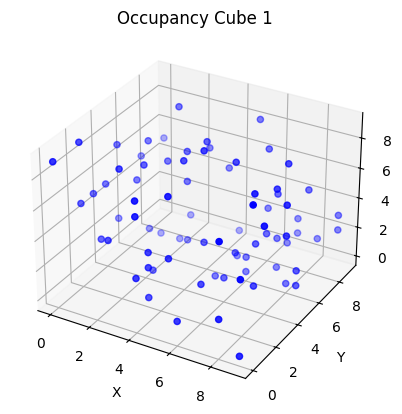

In [33]:
# Visualize the first two occupancy cubes
for i in [0]:
    cube = input_dataset[i]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract indices of occupied voxels
    x, y, z = np.nonzero(cube)

    # Plot occupied voxels
    ax.scatter(x, y, z, c='b', marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.title(f'Occupancy Cube {i+1}')
    plt.show()


In [34]:
for cube in input_dataset[0]:
    print(cube)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0.

In [37]:
# DEVELOP MY OWN OCCUPANCY CUBE(S)
cube_shape = (10, 10, 10) # dimensions of the occupancy cube i.e. (x,y,z)

occupancy_cube = np.zeros(cube_shape) # creates an array of zeros; (10, 10, 10) will produce a cube 10 zeroes cubed.

# Manually occupy certain voxels
occupancy_cube[0, 1, 2] = 1 # change the value of at (x = 3, y = 4, z = 5) from '0' to '1'
occupancy_cube[7, 8, 9] = 0 # change the value of at (x = 7, y = 8, z = 9) from '0' to '1'

# Something to really remember -> python will start a sequence at '0'
# Therefore, if you want to occupy the coordinate (1, 2, 3) -> in python that is (1, 2, 3)

# You can create more occupancy cubes in a similar way if needed

print(occupancy_cube) # this is 2D representation of the occupancy_cube

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0

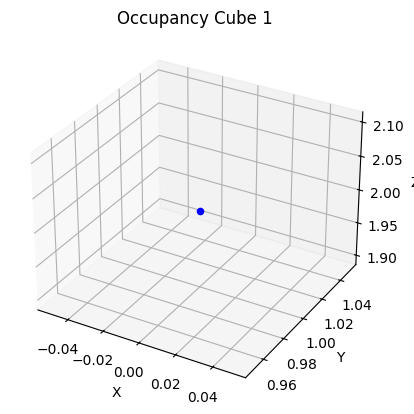

In [45]:
# this is a 3D representation
cube = occupancy_cube
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract indices of occupied voxels
x, y, z = np.nonzero(occupancy_cube)

# Plot occupied voxels
ax.scatter(x, y, z, c='b', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title(f'Occupancy Cube {i+1}')
plt.show()

In [24]:
print(input_dataset[0:1]) # notice the difference in number of brackets at the start of the first matrix...

[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
   [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
   [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
   [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
   [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
   [0. 1. 0. 0. 